# 📊 Pythonic Finance: Analyze Company Fundamentals with SEC EDGAR APIs

Analyze company's fundamentals with Python and SEC EDGAR APIs.

## Details

For more details and base theoretical knowledge, please consult the slide that I presented in PyCon.

## Important Disclaimer

This notebook is for educational purposes ONLY.
The information and code provided are intended to demonstrate how to programmatically access and
analyze publicly available data from the U.S. Securities and Exchange Commission (SEC).
It is NOT financial, investment, or trading advice. Do not use this for making investment decisions.
All company examples are for demonstration. Past performance is not indicative of future results.
Always conduct your own research or consult a qualified financial advisor.

## Setup: Importing Necessary Libraries

We'll use these Python libraries:
- `requests`: To send HTTP requests to the SEC EDGAR API (to get the data).
- `pandas`: For organizing and analyzing data in a table-like structure (`DataFrame`).
- `matplotlib.pyplot` and `seaborn`: For creating charts to visualize trends.
- `pydantic`: To define and validate the structure of the data we expect from the API.

In [1]:
import time
from typing import Dict, Optional, Any

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
from pydantic import BaseModel, Field, ValidationError

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

## Define Options

Company to analyze, period, tickers, etc. In this example, we are going to be analyzing `Alphabet Inc.` with the CIK of `1652044`.

More companies that we could test:

- `NVIDIA Corp`: `1045810`
- `Spotify Technology S.A.`: `1639920` (this is a foreign private issuer)
- `Microsoft Corp`: `789019`
- `Meta Platforms, Inc.`: `1326801`
- `Tesla, Inc.`: `1318605`

In [2]:
analysis_options = {
    "cik": "1652044",
    "user-agent": "PyCon 2025 Demo"
}

## Pydantic Models: Defining Expected Data Structures

We're going to define required data structures so we can process and analyze the data more easily.

In [3]:
class FactValue(BaseModel):
    fy: Optional[int] = None
    fp: Optional[str] = None
    form: Optional[str] = None
    filed: Optional[str] = None
    val: Optional[float] = None
    accn: Optional[str] = None
    end: Optional[str] = None
    start: Optional[str] = None
    frame: Optional[str] = None

class FactDetail(BaseModel):
    label: Optional[str] = None
    description: Optional[str] = None
    units: Dict[str, list[FactValue]]

class UsGaapFactsSpecific(BaseModel):
    RevenueFromContractWithCustomerExcludingAssessedTax: Optional[FactDetail] = None
    NetIncomeLoss: Optional[FactDetail] = None
    Assets: Optional[FactDetail] = None
    Liabilities: Optional[FactDetail] = None # Still include for direct extraction attempt, if it were available
    StockholdersEquity: Optional[FactDetail] = None
    Revenues: Optional[FactDetail] = None
    SalesRevenueNet: Optional[FactDetail] = None
    StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest: Optional[FactDetail] = None

class CompanyFactsData(BaseModel):
    us_gaap: Optional[UsGaapFactsSpecific] = Field(None, alias='us-gaap')

class CompanyFactsResponse(BaseModel):
    cik: int
    entityName: str
    facts: CompanyFactsData

print("Pydantic models defined.")

Pydantic models defined.


## Fetch Company Data

Fetch the company's data from the SEC's EDGAR API with `requests`. At the same time, check for any potential errors that happen!

In [4]:
def fetch_company_data(cik: str) -> dict[str, Any]:
    """Fetches and validates company data from the SEC EDGAR companyfacts API."""

    # `zfill` is important since leading zeroes is how their API is handling CIKs.
    api_url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik.zfill(10)}.json"

    try:
        response = requests.get(api_url, headers={"User-Agent": analysis_options["user-agent"]})
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"HTTP request error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


json_data = fetch_company_data(analysis_options["cik"])
print(f"Successfully fetched data for {analysis_options['cik']}.")

Successfully fetched data for 1652044.


## Observe Raw Company Data

We can see the company data below.

In [5]:
json_data

{'cik': 1652044,
 'entityName': 'Alphabet Inc.',
 'facts': {'dei': {'EntityPublicFloat': {'label': 'Entity Public Float',
    'description': "The aggregate market value of the voting and non-voting common equity held by non-affiliates computed by reference to the price at which the common equity was last sold, or the average bid and asked price of such common equity, as of the last business day of the registrant's most recently completed second fiscal quarter.",
    'units': {'USD': [{'end': '2015-06-30',
       'val': 0,
       'accn': '0001652044-16-000012',
       'fy': 2015,
       'fp': 'FY',
       'form': '10-K',
       'filed': '2016-02-11'},
      {'end': '2015-06-30',
       'val': 0,
       'accn': '0001652044-16-000022',
       'fy': 2015,
       'fp': 'FY',
       'form': '8-K',
       'filed': '2016-05-03',
       'frame': 'CY2015Q2I'},
      {'end': '2016-06-30',
       'val': 413800000000,
       'accn': '0001652044-17-000008',
       'fy': 2016,
       'fp': 'FY',
    

## The Problem: Raw Data is Wild 🦁

As we can see from the response before, API data can be messy, inconsistent, or missing fields. How do we tame it?

We need a way to guarantee the data we fetch matches the structure we expect.

This is where `pydantic` comes in! Once passing the validation, we can be sure that it's guaranteed to be in the format that we want, in the data structure that we want. It will throw an error if it fails the parsing stage.

In [6]:
def validate_company_data(data: dict[str, Any]) -> CompanyFactsResponse:
    """Make sure that the `company_facts` dataset is according to our expectations."""
    try:
        company_facts = CompanyFactsResponse.model_validate(data)
        return company_facts
    except ValidationError as e:
        print(f"Data Validation Error (Pydantic): {e}")


company_facts = validate_company_data(json_data)
print(f"Successfully validated data for: {company_facts.entityName}")

Successfully validated data for: Alphabet Inc.


## Observe Company Facts

After fetching, we can see the company's facts.

In [7]:
company_facts.model_dump_json(indent=2)

'{\n  "cik": 1652044,\n  "entityName": "Alphabet Inc.",\n  "facts": {\n    "us_gaap": {\n      "RevenueFromContractWithCustomerExcludingAssessedTax": {\n        "label": "Revenue from Contract with Customer, Excluding Assessed Tax",\n        "description": "Amount, excluding tax collected from customer, of revenue from satisfaction of performance obligation by transferring promised good or service to customer. Tax collected from customer is tax assessed by governmental authority that is both imposed on and concurrent with specific revenue-producing transaction, including, but not limited to, sales, use, value added and excise.",\n        "units": {\n          "USD": [\n            {\n              "fy": 2018,\n              "fp": "FY",\n              "form": "10-K",\n              "filed": "2019-02-05",\n              "val": 90272000000.0,\n              "accn": "0001652044-19-000004",\n              "end": "2016-12-31",\n              "start": "2016-01-01",\n              "frame": "CY

## Create Fundamentals Data Frame

Developing the fundamentals DataFrame is a crucial step for our analysis. This involves transforming the data fetched from the SEC EDGAR API into a structured format suitable for calculations and visualization.

Here are the key processes involved in creating this DataFrame:

### Data Conversion

We convert the validated data, which is currently in a Pydantic model structure, into a pandas DataFrame. This provides a flexible table-like format for data manipulation.

### Handling Metric Variations

Financial reporting standards (US GAAP) sometimes use different tags or names for essentially the same financial metric (e.g., different ways to report `Revenue` or `Equity`). This step involves identifying these variations and mapping them to a single, consistent column name in our `DataFrame`. We prioritize specific tags and handle cases where a preferred tag might be missing, attempting to use alternative tags for the same metric.

One individual tried to put a mapping of all possible derivations in [this repository](https://github.com/Nneoma-Ihueze/SEC-Mapping).

### Deriving Metrics

Some metrics, like `Liabilities`, are not always reported directly but can be derived from others (`Assets` - `Equity`). We calculate these derived metrics to complete our dataset.

In [8]:
def get_financial_statement_mapping_from_xbrl_property():
    """
    Financial reports would sometimes use different names for essentially the same
    financial metric, so we have to extract it.
    """
    return {
        "Revenue": ["RevenueFromContractWithCustomerExcludingAssessedTax", "Revenues", "SalesRevenueNet"],
        "Net Income": ["NetIncomeLoss"],
        "Assets": ["Assets"],
        "Equity": ["StockholdersEquity", "StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest"]
    }


def extract_annual_data_series(
    company_facts: CompanyFactsResponse,
    pydantic_attribute_to_try: str,
    unit: str = 'USD',
    form_type: str = '10-K',
    fiscal_period: str = 'FY'
) -> Optional[pd.Series]:
    """
    Extracts annual data for a specific fact from the company facts object.
    Filters by unit, form type, and fiscal period.
    """
    # If data is invalid, just return.
    if not company_facts or not company_facts.facts or not company_facts.facts.us_gaap:
        return None

    # Attempt to get a single fact with `getattr`, defaults to `None`.
    us_gaap_data = company_facts.facts.us_gaap
    fact_detail: Optional[FactDetail] = getattr(us_gaap_data, pydantic_attribute_to_try, None)

    # Check if the fact detail or the specified unit within it is missing.
    if not fact_detail or unit not in fact_detail.units:
        return None

    data_points = []
    # Iterate through the fact values for the specified unit.
    for fact_value_obj in fact_detail.units[unit]:
        # Check if required fields are not None and match form type and fiscal period
        if all([
            fact_value_obj.end is not None,
            fact_value_obj.val is not None,
            fact_value_obj.form == form_type,
            fact_value_obj.fp == fiscal_period
        ]):
            data_points.append({'date': pd.to_datetime(fact_value_obj.end), 'value': fact_value_obj.val})

    # If no data points were found after filtering.
    if not data_points:
        return None

    # Create DataFrame, drop duplicates by date, set index, and sort
    temp_df = pd.DataFrame(data_points).drop_duplicates(subset=['date'], keep='last').set_index('date').sort_index()

    return temp_df['value']


def create_fundamentals_dataframe(company_facts_obj: CompanyFactsResponse) -> pd.DataFrame:
    df = pd.DataFrame()
    # Return empty DataFrame if company facts object is missing
    if not company_facts_obj:
        return df
    print(f"\nExtracting metrics for {company_facts_obj.entityName}...")

    # Extracted columns that we want.
    essential_extracted_cols = ['Revenue', 'Net Income', 'Assets', 'Equity']
    metrics_extraction_config = get_financial_statement_mapping_from_xbrl_property()

    # Iterate through each metric to extract data.
    for df_col_name, pydantic_attr_list in metrics_extraction_config.items():
        metric_series: Optional[pd.Series] = None
        used_tag = None
        latest_date = pd.Timestamp.min

        # Iterate through potential Pydantic attributes for the current metric.
        for p_attr in pydantic_attr_list:
            # Attempt to extract the data series for the current attribute.
            series_attempt = extract_annual_data_series(company_facts_obj, p_attr)
            # If data is successfully extracted and not empty.
            if series_attempt is not None and not series_attempt.empty:
                current_latest_date = series_attempt.index.max()
                # If this is the first series found or it has a later latest date, use it.
                if metric_series is None or current_latest_date > latest_date:
                    metric_series = series_attempt
                    used_tag = p_attr
                    latest_date = current_latest_date

        # If a data series was successfully found for the metric.
        if metric_series is not None:
            df[df_col_name] = metric_series
            # Print a note if a fallback tag was used.
            if used_tag != pydantic_attr_list[0] and len(pydantic_attr_list) > 1:
                print(f"Note: For '{df_col_name}', using data from Pydantic attribute '{used_tag}'.")

        # If an essential metric could not be extracted.
        elif df_col_name in essential_extracted_cols:
            print(f"CRITICAL: Essential metric '{df_col_name}' could not be extracted for {company_facts_obj.entityName}.")
            return pd.DataFrame() # Fail fast if an essential extracted metric is missing

    # Check if essential metrics are present and have non-null data after extraction.
    if df.empty or not all(col in df.columns and not df[col].isnull().all() for col in essential_extracted_cols):
        print(f"  CRITICAL: Essential metrics missing or all NaN after extraction for {company_facts_obj.entityName}. Aborting.")
        return pd.DataFrame()

    # Derive Liabilities (now that Assets and Equity are confirmed or we've exited).
    print("  Note: 'Liabilities' column derived as (Assets - Equity).")
    df['Liabilities'] = df['Assets'] - df['Equity']

    # Sort the DataFrame by index (date) if not already monotonic increasing.
    if not df.index.is_monotonic_increasing:
        df = df.sort_index(ascending=True)
    return df


df_fundamentals = create_fundamentals_dataframe(company_facts)


Extracting metrics for Alphabet Inc....
  Note: 'Liabilities' column derived as (Assets - Equity).


## Observe `DataFrame`

Now that we're done with the data extraction and tidying it up, we can now inspect the results of our work. At the moment, we're displaying the latest 5 years.

In [9]:
display_cols_fund = [col for col in ['Revenue', 'Net Income', 'Assets', 'Liabilities', 'Equity'] if col in df_fundamentals.columns]

# Check if the list of display columns is not empty AND the DataFrame itself is not empty.
if display_cols_fund and not df_fundamentals.empty:
    # Directly format and display the data
    styled_fundamentals = df_fundamentals[display_cols_fund].tail().rename_axis("Fiscal Year End").style.format('{:,.0f}', na_rep='N/A')
    display(styled_fundamentals)
else:
    print("No fundamental columns with data to display.")

## Understanding the Core Financial Metrics

Before diving into financial ratios, let's understand the core metrics we've extracted and are now viewing in the DataFrame:

### Revenue

This is the total amount of income generated by the sale of goods or services related to the company's primary operations. It's often referred to as the "top line" because it's the first line on an income statement.

### Net Income

Also known as profit or earnings, Net Income is the remaining amount of revenue after deducting all costs, expenses, interest, and taxes. It represents the company's profitability and is often referred to as the "bottom line."

### Assets

These are resources owned or controlled by a company as a result of past events and from which future economic benefits are expected to flow to the entity. Assets can include cash, accounts receivable, inventory, property, plant, and equipment.

### Liabilities

These are obligations of the company arising from past events, the settlement of which is expected to result in an outflow from the entity of resources embodying economic benefits. Liabilities include accounts payable, salaries payable, and long-term debt.

### Equity

Also known as shareholders' equity or stockholders' equity, this represents the residual interest in the assets of the entity after deducting all its liabilities. It's the value that would be returned to a company's shareholders if all assets were liquidated and all debts were paid off.

## Calculate Financial Metrics (Ratios)

After successfully processing our `DataFrame` in a format that we would ideally operate with, we can continue by calculating financial ratios.

In [10]:
def calculate_ratios(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    print("\nCalculating Financial Ratios...")
    df_ratios = df.copy()

    try:
        df_ratios['Net Profit Margin (%)'] = df_ratios.apply(lambda r: (r['Net Income']/r['Revenue'])*100 if pd.notnull(r['Revenue']) and r['Revenue']!=0 else pd.NA, axis=1)
        print("- Calculated Net Profit Margin.")
    except KeyError:
        print("  Warning: Could not calculate Net Profit Margin, missing Revenue or Net Income.")
        df_ratios['Net Profit Margin (%)'] = pd.NA

    try:
        df_ratios['Debt-to-Equity Ratio'] = df_ratios.apply(lambda r: r['Liabilities']/r['Equity'] if pd.notnull(r['Equity']) and r['Equity'] != 0 else pd.NA, axis=1)
        print("- Calculated Debt-to-Equity Ratio.")
    except KeyError:
        print("  Warning: Could not calculate Debt-to-Equity, missing Liabilities or Equity."); df_ratios['Debt-to-Equity Ratio']=pd.NA

    return df_ratios

ratios = calculate_ratios(df_fundamentals)


Calculating Financial Ratios...
- Calculated Net Profit Margin.
- Calculated Debt-to-Equity Ratio.


## Observe Financial Metrics

After calculation, observing the financial metrics becomes possible.

In [11]:
ratios

Revenue    Net Income        Assets        Equity  \
date                                                                 
2016-12-31  9.027200e+10  1.947800e+10  1.674970e+11  1.390360e+11   
2017-12-31  1.108550e+11  1.266200e+10  1.972950e+11  1.525020e+11   
2018-12-31  1.368190e+11  3.073600e+10  2.327920e+11  1.776280e+11   
2019-12-31  1.618570e+11  3.434300e+10  2.759090e+11  2.014420e+11   
2020-12-31  1.825270e+11  4.026900e+10  3.196160e+11  2.225440e+11   
2021-12-31  2.576370e+11  7.603300e+10  3.592680e+11  2.516350e+11   
2022-12-31  2.828360e+11  5.997200e+10  3.652640e+11  2.561440e+11   
2023-12-31  3.073940e+11  7.379500e+10  4.023920e+11  2.833790e+11   
2024-12-31  3.500180e+11  1.001180e+11  4.502560e+11  3.250840e+11   

             Liabilities  Net Profit Margin (%)  Debt-to-Equity Ratio  
date                                                                   
2016-12-31  2.846100e+10              21.577012              0.204702  
2017-12-31  4.479300e+10              11.422128              0.293721  
2018-12-31  5.516400e+10              22.464716              0.310559  
2019-12-31  7.446700e+10              21.218112              0.369670  
2020-12-31  9.707200e+10              22.061942              0.436192  
2021-12-31  1.076330e+11              29.511677              0.427735  
2022-12-31  1.091200e+11              21.203807              0.426010  
2023-12-31  1.190130e+11              24.006649              0.419978  
2024-12-31  1.251720e+11              28.603672              0.385045

## Understanding Financial Ratios: Net Profit Margin and Debt-to-Equity

Now that we have calculated some key financial ratios, let's understand what they represent:

### Net Profit Margin

This ratio measures how much net income or profit is generated as a percentage of revenue. It's a key indicator of a company's profitability and operational efficiency. A higher net profit margin generally suggests that a company is more effective at converting revenue into actual profit.

- Formula: `(Net Income / Revenue) * 100`

A 20% Net Profit Margin means that for every dollar of revenue, the company earns 20 cents in profit after all expenses, interest, and taxes are paid.

### Debt to Equity Ratio

This ratio is a measure of a company's financial leverage. It indicates how much debt a company is using to finance its assets relative to the value of shareholders' equity. In simpler terms, it shows how much debt a company has compared to the value of its ownership stake.

- Formula: `Total Liabilities / Shareholder Equity`

A Debt-to-Equity Ratio of 0.5 means the company uses 50 cents of debt for every dollar of shareholder equity. A higher ratio indicates that the company is using more debt financing, which can increase risk but also potentially magnify returns.

## Summary Table

After calculating the ratios, we can display a formatted summary table of the financials and ratios.

In [12]:
def display_summary_table(df: pd.DataFrame, company_name: str):
    """Displays a formatted summary table of the financials and ratios."""
    if df.empty:
        print(f"No data to display for {company_name}.")
        return

    # Define columns that we want to appear.
    cols = [
        "Revenue",
        "Net Income",
        "Assets",
        "Liabilities",
        "Equity",
        "Net Profit Margin (%)",
        "Debt-to-Equity Ratio"
    ]

    disp_cols = [c for c in cols if c in df.columns]
    if not disp_cols:
        print("No relevant columns for summary.")
        return

    summary = df[disp_cols].tail().copy()
    num_fmt = lambda x: f"{x:,.0f}" if pd.notnull(x) else "N/A"
    pct_fmt = lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A"
    ratio_fmt = lambda x: f"{x:.2f}" if pd.notnull(x) else "N/A"

    # Define formatters in a dictionary
    all_formatters = {
        'Revenue': num_fmt,
        'Net Income': num_fmt,
        'Assets': num_fmt,
        'Liabilities': num_fmt,
        'Equity': num_fmt,
        'Net Profit Margin (%)': pct_fmt,
        'Debt-to-Equity Ratio': ratio_fmt
    }

    # Apply formatters only if the column exists in the summary DataFrame
    formatters_to_apply = {col: all_formatters[col] for col in disp_cols if col in all_formatters}
    styled_summary = summary.rename_axis('Fiscal Year End').style.format(formatters_to_apply, na_rep='N/A')
    display(styled_summary)


display_summary_table(ratios, company_facts.entityName)

## Plotting Ratios and Graphs - `Revenue and Net Income`

Our data is really sharp and clean now, we can immediately plot our graphs. The first graph that we're going to make is `Revenue and Net Income Over Time`


Plotting Revenue & Net Income for Alphabet Inc....


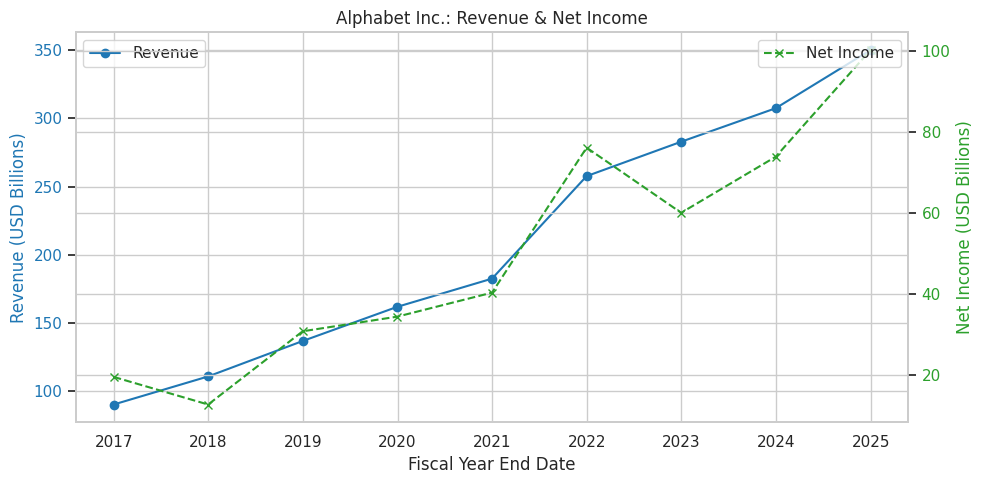

In [13]:
def plot_revenue_and_net_income(df: pd.DataFrame, company_name: str):
    """Plots Revenue and Net Income on a dual-axis graph."""
    if df.empty or ('Revenue' not in df and 'Net Income' not in df):
        print(f"  Skipping Revenue/Net Income plot for {company_name}: insufficient data.")
        return

    plot_data = df[['Revenue', 'Net Income']].dropna(how='all')
    if len(plot_data.dropna(subset=['Revenue'])) < 2 and len(plot_data.dropna(subset=['Net Income'])) < 2:
         print(f"  Skipping Revenue/Net Income plot for {company_name}: insufficient data points with values.")
         return

    print(f"\nPlotting Revenue & Net Income for {company_name}...")
    fig, ax1 = plt.subplots(figsize=(10, 5))

    if 'Revenue' in plot_data and len(plot_data['Revenue'].dropna()) >= 2:
        ax1.plot(plot_data.index, plot_data['Revenue']/1e9, color='tab:blue', marker='o', label='Revenue')
        ax1.set_ylabel('Revenue (USD Billions)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')
        ax1.set_xlabel('Fiscal Year End Date') # Set xlabel on the primary axis

    ax2 = ax1.twinx() # Create a second y-axis
    if 'Net Income' in plot_data and len(plot_data['Net Income'].dropna()) >= 2:
        ax2.plot(plot_data.index, plot_data['Net Income']/1e9, color='tab:green', marker='x', linestyle='--', label='Net Income')
        ax2.set_ylabel('Net Income (USD Billions)', color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')
        ax2.legend(loc='upper right')

    plt.title(f'{company_name}: Revenue & Net Income')
    fig.tight_layout()
    plt.show()

plot_revenue_and_net_income(ratios, company_facts.entityName)

### Net Profit Margin Over Time

The Net Profit Margin indicates how much net income or profit is generated as a percentage of revenue. A higher percentage generally indicates a more profitable company.

Plotting Net Profit Margin (%)...


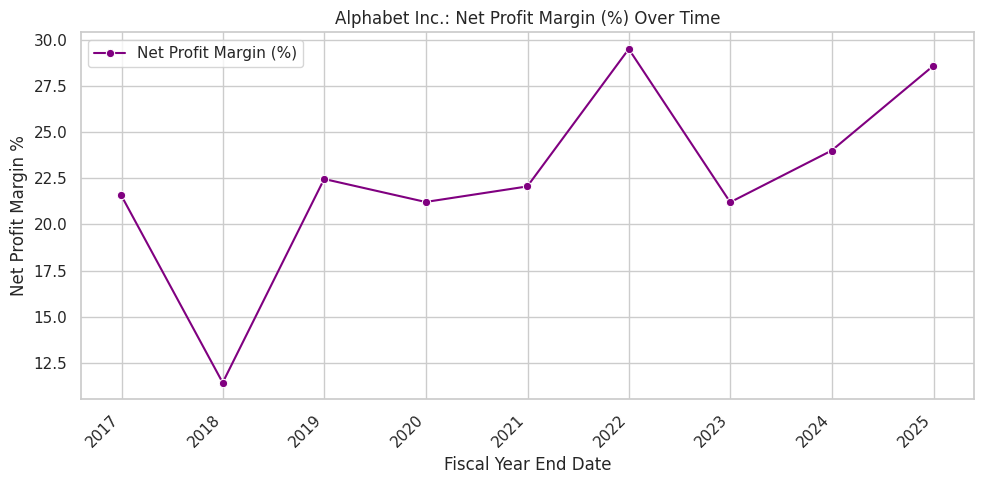

In [14]:
def plot_financial_ratio(df: pd.DataFrame, ratio_col: str, color: str, label_suffix: str = ''):
    """Plots a single financial ratio."""
    if ratio_col not in df or len(df[ratio_col].dropna()) < (1 if 'Debt-to-Equity' in ratio_col else 2):
        print(f"  Skipping {ratio_col} plot: insufficient data.")
        return

    print(f"Plotting {ratio_col}...")
    plt.figure(figsize=(10, 5))

    plot_func = sns.barplot if 'Debt-to-Equity' in ratio_col else sns.lineplot
    plot_kwargs = {'marker':'o'} if 'Debt-to-Equity' not in ratio_col else {}
    x_data = df.index.strftime('%Y-%m-%d') if 'Debt-to-Equity' in ratio_col else df.index

    plot_func(x=x_data, y=df[ratio_col], color=color, label=ratio_col, **plot_kwargs)

    plt.title(f'{company_facts.entityName}: {ratio_col} Over Time')
    plt.xlabel('Fiscal Year End Date')
    plt.ylabel(f'{ratio_col.replace(" (%)","")} {label_suffix}')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_financial_ratio(ratios, 'Net Profit Margin (%)', 'purple', '%')

### Debt-to-Equity Ratio Over Time

The Debt-to-Equity Ratio is a measure of a company's financial leverage, calculated by dividing its total liabilities by its shareholder equity. It indicates how much debt a company is using to finance its assets relative to the value of shareholders' equity.

Plotting Debt-to-Equity Ratio...


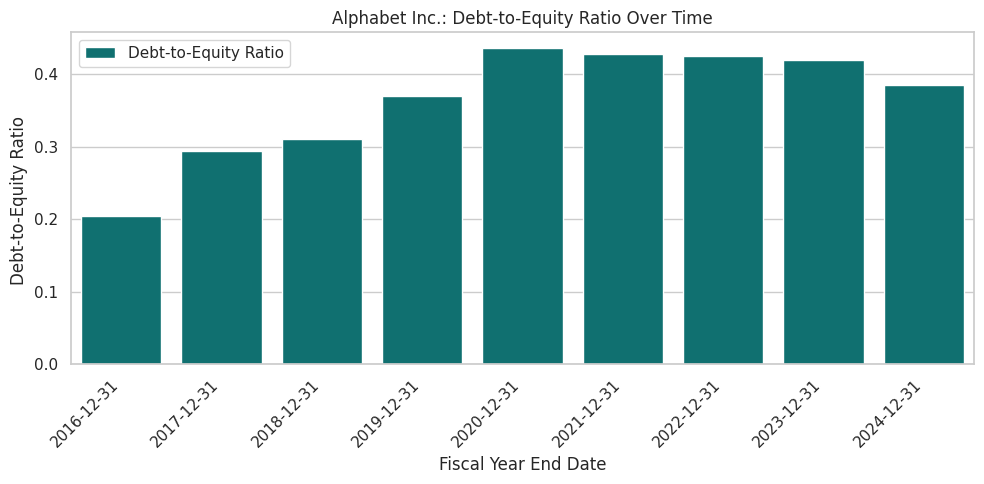

In [15]:
plot_financial_ratio(ratios, 'Debt-to-Equity Ratio', 'teal', '')

## Conclusion

### Experiment

- Used Python to fetch official financial data for public companies from the SEC EDGAR API.
- Validated the data structure using Pydantic for robustness.
- Extracted key metrics like Revenue, Net Income, Assets, Liabilities, and Equity, attempting to use the most appropriate GAAP tags.
- Calculated important ratios like Net Profit Margin and Debt-to-Equity.
- Visualized trends to see how these metrics have changed over time.
- Structured the code into functions for reusability across different companies.

### Data Availability

As seen with some examples, the exact data points and their completeness can vary by company and the specific tags available through the `companyfacts` API. For in-depth research on a specific company, one might need to consult the raw filings or use more targeted SEC APIs.

### Further Exploration

- Analyze more metrics (e.g., Gross Profit, Operating Income, Cash Flow from Operations).
- Calculate other financial ratios (e.g., Current Ratio, Return on Equity).
- Compare metrics directly across multiple companies by collecting DataFrames and then merging/plotting them together.
- Look at quarterly data (10-Q filings) instead of just annual data.
- Investigate why data might be missing or different for certain companies.

Financial analysis is a rich field. This notebook provides a starting point for using Python as a tool to explore it!